# 复赛

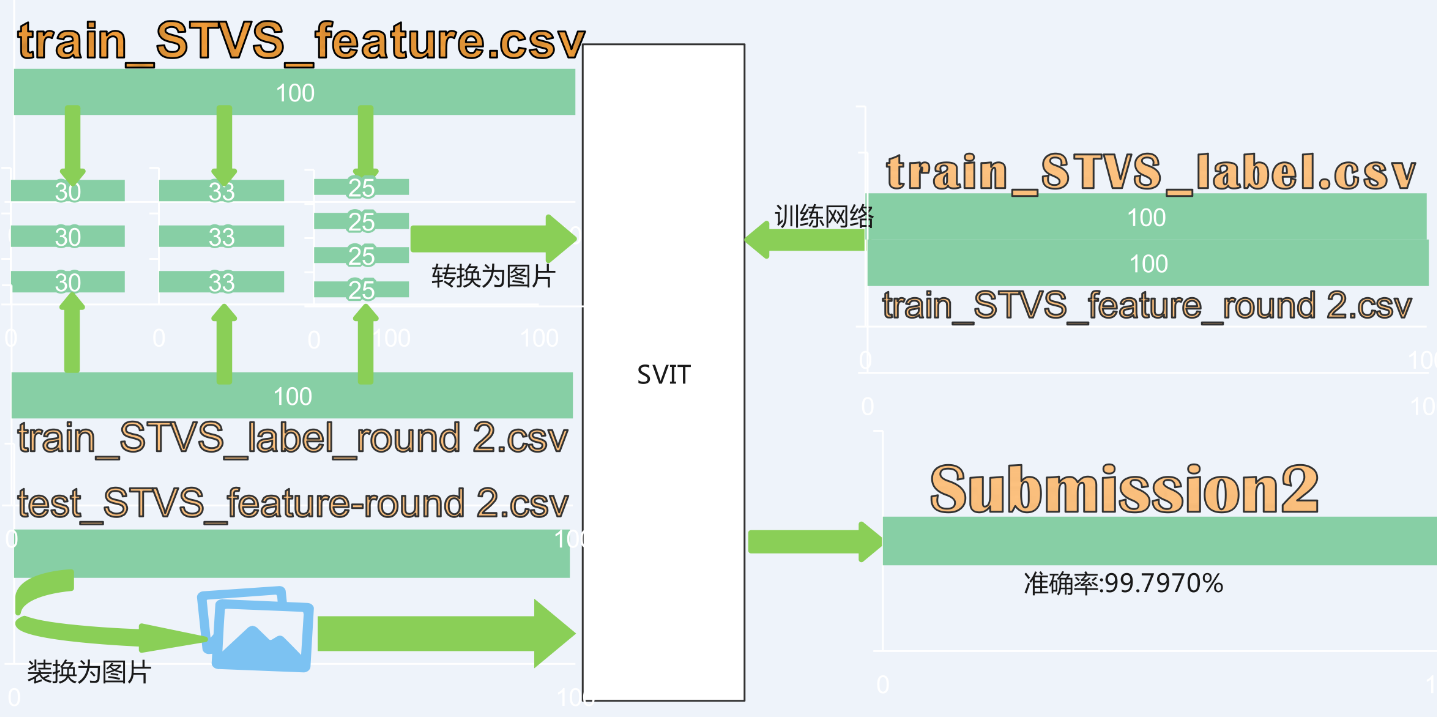

In [ ]:
#在此选择是否使用处理好的数据和预训练模型
use_processed_data = True  #如果为true，将会使用事先处理好的数据，不使用则正常处理数据
use_pretrain_model = True  #如果为True，将会使用预训练模型，并直接出预测结果，不使用则正常训练

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if(use_processed_data):#如果使用预处理数据，只读取标签
    label_origion1=pd.read_csv('data_train_r1/train_STVS_label.csv',header=None)
    label_origion2=pd.read_csv('train_STVS_data_round 2/train_STVS_label_round 2.csv',header=None)

else:#否则读取所有数据
    train_origion1=pd.read_csv('data_train_r1/train_STVS_feature.csv',header=None)
    test_origion1= pd.read_csv('data_test_r1/test_STVS_feature.csv',header=None)
    label_origion1=pd.read_csv('data_train_r1/train_STVS_label.csv',header=None)

    test_origion2 = pd.read_csv('test_STVS_feature-round 2/test_STVS_feature-round 2.csv',header=None)
    train_origion2=pd.read_csv('train_STVS_data_round 2/train_STVS_feature_round 2.csv',header=None)
    label_origion2=pd.read_csv('train_STVS_data_round 2/train_STVS_label_round 2.csv',header=None)


In [2]:
#数据预处理函数一，每隔两个点的数据作为一组，即将100%的数据平均分为3份33%的数据
def getidx33(train_origion):
    idx1,idx2,idx3,idx=[],[],[],[] #分组的索引
    for j in range(33):        
        for i in range(1,40):
            idx1.append(i+0+117*j-1)
            idx2.append(i+39+117*j-1)
            idx3.append(i+78+117*j-1)
            idx.append(i+39*j-1)
            
    step = 3900 - 39
    for k in range(13):
        idx1.append(step + 0 + 3*k )
        idx2.append(step + 1 + 3*k )
        idx3.append(step + 2 + 3*k )
        idx.append(1287+k)
        
        
  
    #根据索引获取数据
    train1,train2,train3=train_origion.iloc[:,idx1],train_origion.iloc[:,idx2],train_origion.iloc[:,idx3]  
    train1.columns,train2.columns,train3.columns=idx,idx,idx

    #生成新数据及其索引
    train_three=pd.concat([train1,train2,train3],axis=0,ignore_index=True)
    
    return train_three

#数据预处理函数二，先去除10%的数据，然后每隔两个点的数据分为一组，平均分为三份。
def getidx30(train_origion):
    idx1,idx2,idx3,idx4,idx=[],[],[],[],[]  
    for j in range(30):        #获取数据的索引
        for i in range(1,40):
            idx1.append(i+0+117*j-1)      #去除后10%的数据
            idx2.append(195+i+39+117*j-1) #去除前5%的数据，后5%的数据
            idx3.append(390+i+78+117*j-1) #去除前10%的数据
            idx.append(i+39*j-1)
    
    #根据索引获取数据
    train1,train2,train3=train_origion.iloc[:,idx1],train_origion.iloc[:,idx2],train_origion.iloc[:,idx3]  
    train1.columns,train2.columns,train3.columns=idx,idx,idx

    #生成新数据及其索引
    train_three=pd.concat([train1,train2,train3],axis=0,ignore_index=True)
    
    return train_three

#数据预处理函数三，每隔3个点的数据分为一组，平均分为四份。
def getidx25(train_origion):
    idx1,idx2,idx3,idx4,idx=[],[],[],[],[]  
    for j in range(25):        #获取数据的索引
        for i in range(1,40):
            idx1.append(i+0+156*j-1)
            idx2.append(i+39+156*j-1)
            idx3.append(i+78+156*j-1)
            idx4.append(i+117+156*j-1)
            idx.append(i+39*j-1)
    
    #根据索引获取数据
    train1,train2,train3,train4=train_origion.iloc[:,idx1],train_origion.iloc[:,idx2],train_origion.iloc[:,idx3],train_origion.iloc[:,idx4]    
    train1.columns,train2.columns,train3.columns,train4.columns=idx,idx,idx,idx

    #生成新数据及其索引
    train_three=pd.concat([train1,train2,train3,train4],axis=0,ignore_index=True)
    
    return train_three

In [3]:
#将原数据装换成图片格式的函数
size=224           #图片大小，长宽一致
def to_image(data):
    index = data.shape[0]      #获取行数
    columns= data.shape[1]     #获取列数
    target = torch.zeros((index,size, size))   #目标格式（图片数，H，W）
    scale = columns / size                  #缩放比例
    for i in tqdm(range(index)):
        for j in range(columns):
            h = size-1- int(data.iloc[i,j] * 100/140*size)       #将数值的范围映射到图片的y轴上
            w = int(j//scale)                                    #代表第几组点
            target[i,h,w] += 1                                   #将值添加1
    return target

In [4]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if(use_processed_data):  
    train_data1=torch.load('train_data1.pt',map_location=device).to(device)
    
    train_data2=torch.load('train_data2.pt',map_location=device).to(device)
    test_data2=torch.load('test_data2.pt',map_location=device).to(device)
    
else:
    #初赛数据
    train_three11=getidx25(train_origion1)
    train_three12=getidx30(train_origion1)
    train_three13=getidx33(train_origion1) 
    
    train_data11=to_image(train_three11).to(device)
    train_data12=to_image(train_three12).to(device)
    train_data13=to_image(train_three13).to(device)
    
    train_data=torch.cat((train_data11,train_data12,train_data13),dim=0)
    torch.save(train_data,'./train_data1.pt')
    
    #复赛数据
    train_three21=getidx25(train_origion2)
    train_three22=getidx30(train_origion2)
    train_three23=getidx33(train_origion2) 
    
    train_data21=to_image(train_three21).to(device)
    train_data22=to_image(train_three22).to(device)
    train_data23=to_image(train_three23).to(device)
    
    train_data=torch.cat((train_data21,train_data22,train_data23),dim=0)
    torch.save(train_data,'./train_data2.pt')
    
    test_data=to_image(test_origion2).to(device)
    torch.save(test_data,'./test_data2.pt')


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


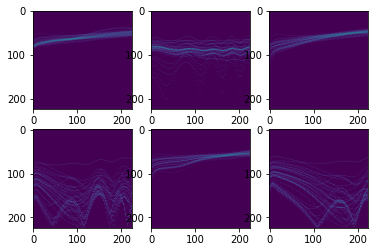

In [5]:

import matplotlib.pyplot as plt
for i in range(6):
    img = to_image(train_origion2.iloc[[i+154]])[0]#.cpu()
    fig = plt.figure('show picture')
    exec('ax = fig.add_subplot(23%d)'%(i+1))
    ax.imshow(img)
plt.show()


In [6]:
label_three1=pd.concat([label_origion1,label_origion1,label_origion1,label_origion1,label_origion1,label_origion1,label_origion1,label_origion1,label_origion1,label_origion1],axis=0,ignore_index=True)
#将标签处理为分类问题的标签
label1=pd.concat([label_three1,-label_three1],axis=1)
torch_label1=label1.copy()
for i in tqdm(range(len(torch_label1))):
    if(torch_label1.iloc[i,0]==-1):
        torch_label1.iloc[i,0]=0
    if(torch_label1.iloc[i,1]==-1):
        torch_label1.iloc[i,1]=0
trian1_label=torch.tensor(torch_label1.values).to(device)

label_three2=pd.concat([label_origion2,label_origion2,label_origion2,label_origion2,label_origion2,label_origion2,label_origion2,label_origion2,label_origion2,label_origion2],axis=0,ignore_index=True)
#将标签处理为分类问题的标签
label2=pd.concat([label_three2,-label_three2],axis=1)
torch_label2=label2.copy()
for i in tqdm(range(len(torch_label2))):
    if(torch_label2.iloc[i,0]==-1):
        torch_label2.iloc[i,0]=0
    if(torch_label2.iloc[i,1]==-1):
        torch_label2.iloc[i,1]=0
trian2_label=torch.tensor(torch_label2.values).to(device)

100%|██████████| 50000/50000 [00:09<00:00, 5535.01it/s]


In [7]:

import gc
del train_origion2,label_origion2,test_origion2
gc.collect()
train_data.shape,test_data.shape,torch_label1.shape


(torch.Size([50000, 224, 224]), torch.Size([4927, 224, 224]), (25000, 2))

In [8]:

import torch
from torch.utils.data import Dataset

class Traindataset(Dataset):
    def __init__(self,label1):
        self.label = label1.to(torch.float32)

    def __getitem__(self, index):
        return index

    def __len__(self):
        return len(self.label)

class Validdataset(Dataset):
    def __init__(self,label1):
        self.label = label1.to(torch.float32)

    def __getitem__(self, index):
        return index

    def __len__(self):
        return len(self.label)

In [9]:
!pip install einops
!pip install timm

from coatnet import *
import torch.nn as nn

def getnet(net,if_data=False):
    if(net=='coat'):
        if(if_data==False):return coatnet_1(num_classes=2)
        else:return torch.load('coat.pth',map_location=device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 490.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.7/548.7 kB 2.3 MB/s eta 0:00:00


In [10]:
import torch.nn as nn
from torchvision import transforms, datasets
import json
import os
import torch.optim as optim
import torch
import time
from torch.optim import lr_scheduler

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net=getnet('coat'，use_pretrain_model).to(device)  #这里定义了是否使用预训练模型
print(device)


batchsize=8
less_valloss = 10000.0
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer,step_size=1,gamma = 0.5)

train_dataset_total = Traindataset(trian2_label)
train_loader_total = torch.utils.data.DataLoader(train_dataset_total,batch_size=batchsize, shuffle=True,drop_last=True)
val_dataset_total = Validdataset(trian1_label)
val_loader_total = torch.utils.data.DataLoader(val_dataset_total,batch_size=batchsize, shuffle=False,drop_last=True)

for epoch in range(int(16+32/batchsize)): 
    #break
    
    #复赛数据训练
    train_loss = 0.0
    net.train()
    for step1,idx in enumerate(train_loader_total):  
        optimizer.zero_grad()
        outputs = net(train_data[idx].view(batchsize,1,size,size).to(torch.float32))
        loss = loss_function(outputs, trian2_label[idx].to(torch.float32))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        #print("\rtrain loss: {:^3.0f}%[{}->{}]{:.3f}".format(int((step1 + 1) / len(train_loader_total)* 100), "*" * int((step1 + 1) / len(train_loader_total) * 50), "." * int((1 -(step1 + 1) / len(train_loader_total)) * 50), loss), end="")
        
    #初赛数据训练
    val_loss=0.0  
    for step2,idx in enumerate(val_loader_total):  
        optimizer.zero_grad()
        outputs = net(train_data1[idx].view(batchsize,1,size,size).to(torch.float32))
        loss = loss_function(outputs, trian1_label[idx].to(torch.float32))
        loss.backward()
        optimizer.step()
        val_loss += loss.item()
        #print("\rval_loss: {:^3.0f}%[{}->{}]{:.3f}".format(int((step2 + 1) / len(val_loader_total)* 100), "*" * int((step2 + 1) / len(val_loader_total) * 50), "." * int((1 -(step2 + 1) / len(val_loader_total)) * 50), loss), end="")
    
    scheduler.step()
    print('epoch:',epoch+1,'train_loss:',train_loss,'val_loss:',val_loss)            
    torch.save(net, './Net2_%s.pth'%train_loss)

    if (train_loss<= 0.001 and val_loss <= 0.001):break

/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


cuda:0
epoch: 1 train_loss: 200.18708289264887 val_loss: 27.49941909778614
epoch: 2 train_loss: 49.33459052194114 val_loss: 7.1069345814481215
epoch: 3 train_loss: 14.223166472537118 val_loss: 1.3609127762807036
epoch: 4 train_loss: 4.777338866449981 val_loss: 0.08474167825485157
epoch: 5 train_loss: 0.5840045421411082 val_loss: 0.011854634004562214
epoch: 6 train_loss: 0.021797724456274814 val_loss: 0.0032743083713082655
epoch: 7 train_loss: 0.004849088542278501 val_loss: 7.025592288467664e-05
epoch: 8 train_loss: 0.0004946174357582933 val_loss: 9.670801434324972e-06


In [11]:

import torch
import numpy as np

test=test_data.to(torch.float32)
predit=np.zeros(len(test)) 

with torch.no_grad():
    net.eval()
    for i in tqdm(range(len(test))):
        predit[i]=torch.argmax(net(test[i].reshape(1,1,size,size)))

#将标签装换为原标签
for i in range(len(predit)):
    if(predit[i]==1):
        predit[i]=-1
    if(predit[i]==0):
        predit[i]=1


100%|██████████| 4927/4927 [01:11<00:00, 68.51it/s]


In [12]:

#保存预测结果
import pandas as pd
pd.DataFrame(predit).astype(int).to_csv('Submission2_coat_.csv',index=False,header=None)
len(predit)


4927